In [84]:
import pandas as pd
import numpy as np
from google.cloud import bigquery
import os
from geopy.distance import geodesic
import seaborn as sns
from matplotlib import pyplot as plt

In [55]:
%load_ext google.cloud.bigquery

The google.cloud.bigquery extension is already loaded. To reload it, use:
  %reload_ext google.cloud.bigquery


In [56]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="sunny-footing-321404-513454d4be38.json"
client = bigquery.Client() # Construct a BigQuery client object.

In [57]:
def bigQuery(q: str):
    query_job = client.query(q)  # Make an API request.
    return query_job.to_dataframe().copy() # collect results as a dataframe

# User Type Bike Trips

In [58]:
riders = bigQuery( 
    """
    SELECT subscriber_type as usertype, count(*) as RideCount 
    FROM `bigquery-public-data.san_francisco_bikeshare.bikeshare_trips`
    WHERE start_date >= '2017-01-01 00:00:00' and start_date < '2018-01-01 00:00:00'
    GROUP BY subscriber_type
"""
)

In [59]:
riders.usertype = riders.usertype.dropna()
riders.RideCount = riders.RideCount.astype(int)
riders = riders.sort_values(by='RideCount',ascending=False)[riders['usertype'] != ""]

riders.head()

<ipython-input-59-5faf88de82d1>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  riders = riders.sort_values(by='RideCount',ascending=False)[riders['usertype'] != ""]


,usertype,RideCount
1,Subscriber,409230
0,Customer,110470


<AxesSubplot:xlabel='usertype'>

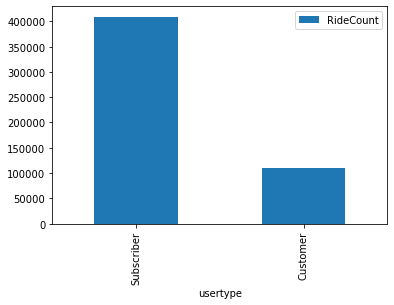

In [60]:
riders.plot(x='usertype', y='RideCount', kind='bar')

In [61]:
#Calculates the average ride time in minutes instead of seconds
userAvgs = bigQuery(
    """
        SELECT subscriber_type as usertype, AVG(duration_sec)/60 as Average_Ride_Time
        FROM `bigquery-public-data.san_francisco_bikeshare.bikeshare_trips`
        WHERE start_date >= '2017-01-01 00:00:00'
        GROUP BY usertype
    """
)

userAvgs = userAvgs[userAvgs['usertype']!='']
userAvgs.head()

,usertype,Average_Ride_Time
0,Subscriber,11.284093
1,Customer,40.605025


In [77]:
# collect results as a dataframe
mostFreqRides = bigQuery(
    """
    SELECT subscriber_type AS usertype, 
    start_station_id,
    end_station_id,
    start_station_latitude,
    start_station_longitude,
    end_station_latitude,
    end_station_longitude,
    count(*) AS Count_of_Trips
    FROM `bigquery-public-data.san_francisco_bikeshare.bikeshare_trips`
    WHERE start_date >= '2017-01-01 00:00:00'
    GROUP BY usertype, start_station_id, end_station_id, start_station_latitude, start_station_longitude,
    end_station_latitude, end_station_longitude
    ORDER BY Count_of_Trips desc
    """
)

mostFreqRides.head()

,usertype,start_station_id,end_station_id,start_station_latitude,start_station_longitude,end_station_latitude,end_station_longitude,Count_of_Trips
0,Subscriber,15,6,37.795392,-122.394203,37.804770,-122.403234,3033
1,Subscriber,6,16,37.804770,-122.403234,37.794130,-122.394430,2846
2,Subscriber,81,15,37.775880,-122.393170,37.795392,-122.394203,2713
3,Customer,15,6,37.795392,-122.394203,37.804770,-122.403234,2510
4,Subscriber,15,81,37.795392,-122.394203,37.775880,-122.393170,2273


In [78]:
distances = []
for start_lat, start_long, end_lat, end_long in zip(mostFreqRides['start_station_latitude'], 
                                                    mostFreqRides['start_station_longitude'],
                                                    mostFreqRides['end_station_latitude'],
                                                    mostFreqRides['end_station_longitude']):
    start = (start_lat, start_long)
    end = (end_lat, end_long)
    distances.append(geodesic(start, end).mi)
mostFreqRides['distance'] = distances
mostFreqRides

,usertype,start_station_id,end_station_id,start_station_latitude,start_station_longitude,end_station_latitude,end_station_longitude,Count_of_Trips,distance
0,Subscriber,15,6,37.795392,-122.394203,37.804770,-122.403234,3033,0.813985
1,Subscriber,6,16,37.804770,-122.403234,37.794130,-122.394430,2846,0.877847
2,Subscriber,81,15,37.775880,-122.393170,37.795392,-122.394203,2713,1.346881
3,Customer,15,6,37.795392,-122.394203,37.804770,-122.403234,2510,0.813985
4,Subscriber,15,81,37.795392,-122.394203,37.775880,-122.393170,2273,1.346881
...,...,...,...,...,...,...,...,...,...
42160,Customer,182,189,37.809013,-122.268247,37.839649,-122.271756,1,2.121617
42161,Customer,182,170,37.809013,-122.268247,37.844493,-122.261351,1,2.475902
42162,Subscriber,182,187,37.809013,-122.268247,37.796248,-122.279352,1,1.069710
42163,Subscriber,182,224,37.809013,-122.268247,37.785157,-122.238915,1,2.298656


In [79]:
monthlyRides = bigQuery(
    """
    SELECT subscriber_type AS usertype,
    EXTRACT(month from start_date) as month,
    count(*) AS numOfTrips
    FROM `bigquery-public-data.san_francisco_bikeshare.bikeshare_trips`
    WHERE start_date >= '2017-01-01 00:00:00' and 
    start_date < '2018-01-01 00:00:00'
    GROUP BY usertype, month
    ORDER BY usertype, month;
    """
)

monthlyRides.head()

,usertype,month,numOfTrips
0,Customer,6,450
1,Customer,7,12978
2,Customer,8,22511
3,Customer,9,24184
4,Customer,10,21411


Text(0.5, 1.0, 'Monthly rides in SF by User Type')

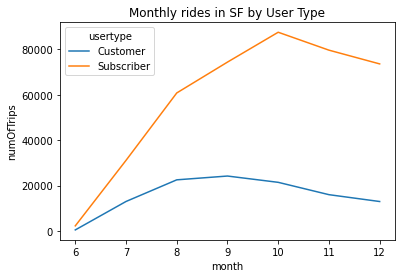

In [80]:
sns.lineplot(x='month',y='numOfTrips', hue='usertype',data=monthlyRides).set_title('Monthly rides in SF by User Type')

# Age Bike Trips

In [81]:
AgeRiders = bigQuery(
    """
    SELECT member_birth_year AS birth_year,
    avg(duration_sec)/60 AS AvgTripDuration,
    count(*) AS trips
    FROM `bigquery-public-data.san_francisco_bikeshare.bikeshare_trips`
    WHERE start_date >= '2017-01-01 00:00:00' and 
    start_date < '2018-01-01 00:00:00'
    GROUP BY birth_year
    ORDER BY trips DESC;
    """
)

In [82]:
AgeRiders=AgeRiders.dropna(axis=0).astype(int)
AgeRiders=AgeRiders[AgeRiders.birth_year >= 1946]
AgeRiders['age'] = 2021 - AgeRiders['birth_year']
AgeRiders.head()

,birth_year,AvgTripDuration,trips,age
1,1985,13,24342,36
2,1988,12,23610,33
3,1987,14,22493,34
4,1984,12,21061,37
5,1982,13,21005,39


Text(0.5, 1.0, 'Total Trips in 2017 by Age in NY')

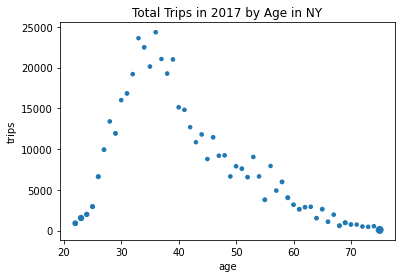

In [85]:
AgeRiders.plot(x='age',y='trips',s='AvgTripDuration',kind='scatter')
plt.title('Total Trips in 2017 by Age in NY')

# Time Bike Trips

In [86]:
bikeHour = bigQuery(
    """
    SELECT
    EXTRACT(hour from start_date) as starthour,
    count(*) AS numOfTrips
    FROM `bigquery-public-data.san_francisco_bikeshare.bikeshare_trips`
    WHERE start_date >= '2017-01-01 00:00:00' and 
    start_date < '2018-01-01 00:00:00'
    GROUP BY starthour
    ORDER BY starthour
    """
)
bikeHour.head()

,starthour,numOfTrips
0,0,2606
1,1,1377
2,2,860
3,3,398
4,4,640


Text(0.5, 1.0, 'Number of Trips in 2017 by Hour')

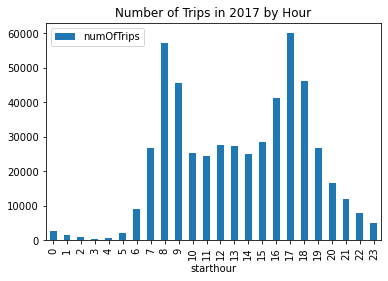

In [87]:
bikeHour.plot(x='starthour',y='numOfTrips',kind='bar').set_title('Number of Trips in 2017 by Hour')

# Survey Manipulation

In [91]:
SFSurvey = pd.read_excel('TDS_2017_Data_WEBPAGE.xlsx', sheet_name = 'Data')
SFSurvey

,*RESPNUM,Q2,Q3,Trips,Q4TOT,Q5TOT,Q4aP,Q4bP,Q4cP,Q4dP,...,Q29,Q30,SAMPLETYPE,LANG,ZONE,Interview_Date,Interview_Day,DRVRFLAG,AGECO,WEIGHT
0,2,1,1.0,19,NaN,NaN,NaN,NaN,NaN,NaN,...,1,1,2,1,NaN,2017-02-07,3,1.0,9,0.773209
1,3,9,NaN,4,2.0,2.0,1.0,5.0,NaN,NaN,...,6,2,2,1,2.0,2017-02-07,3,1.0,4,1.069729
2,9,9,NaN,9,5.0,4.0,2.0,4.0,4.0,3.0,...,1,2,2,1,1.0,2017-02-07,3,1.0,3,0.870043
3,38,7,1.0,33,NaN,NaN,NaN,NaN,NaN,NaN,...,5,1,2,1,NaN,2017-02-07,3,1.0,11,0.893211
4,82,9,NaN,7,5.0,2.0,2.0,4.0,5.0,3.0,...,1,2,2,1,1.0,2017-02-07,3,1.0,3,0.870043
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
799,19435,9,NaN,6,3.0,3.0,1.0,2.0,5.0,NaN,...,2,1,1,4,1.0,2017-04-06,5,1.0,3,0.870043
800,25623,5,1.0,4,NaN,NaN,NaN,NaN,NaN,NaN,...,2,2,2,4,NaN,2017-04-06,5,1.0,7,1.468640
801,5914,6,1.0,3,NaN,NaN,NaN,NaN,NaN,NaN,...,8,2,1,5,NaN,2017-04-07,6,1.0,12,1.229166
802,20034,6,1.0,24,NaN,NaN,NaN,NaN,NaN,NaN,...,5,1,2,5,NaN,2017-04-07,6,NaN,10,0.970089


In [93]:
SFSurvey_data_dictionary = pd.read_excel('TDS_2017_Data_WEBPAGE.xlsx', sheet_name = 'Data Dictionary')
SFSurvey_data_dictionary

,Field,Field Type,Description,Codes
0,RESPNUM,Long Integer,Respondent Number – automatically generated du...,NaN
1,Q2,Integer,In which Bay Area county do you live?,1=Alameda\n2=Contra Costa\n3=Marin\n4=Napa\n5=...
2,Q3,Integer,Have you gone into San Francisco within the pa...,1=Yes\n2=No
3,Trips,Integer,Total trips taken- SF residents: Sum of Q4Tot+...,NaN
4,Q4TOT,Integer,(SF Residents) How many trips did you take yes...,0=Zero \n#=trips taken
...,...,...,...,...
181,Interview Date,Date,Date of the interview,NaN
182,Interview Day,Integer,Day of the week on which the interview was con...,1=Sunday\n2=Monday\n3=Tuesday\n4=Wednesday\n5=...
183,DRVRFLAG,Integer,Indicates respondent drove alone or with other...,1=Yes\n
184,AGECO,Integer,Age code (used for weighting),1=18-24 (Inside SF)\n2=25-34 (Inside SF)\n3=35...


In [95]:
# keep only bikes
SF_survey_bike = SFSurvey[SFSurvey['BIKE'] > 0]
SF_survey_bike # only 19

,*RESPNUM,Q2,Q3,Trips,Q4TOT,Q5TOT,Q4aP,Q4bP,Q4cP,Q4dP,...,Q29,Q30,SAMPLETYPE,LANG,ZONE,Interview_Date,Interview_Day,DRVRFLAG,AGECO,WEIGHT
80,3112,9,NaN,6,2.0,4.0,1.0,5.0,NaN,NaN,...,6,1,2,1,4.0,2017-02-15,4,NaN,3,0.870043
168,6312,9,NaN,4,4.0,0.0,4.0,5.0,1.0,5.0,...,5,1,2,1,4.0,2017-03-08,4,1.0,4,1.069729
201,7984,9,NaN,8,4.0,4.0,1.0,5.0,3.0,5.0,...,7,1,2,1,1.0,2017-03-10,6,1.0,2,1.275871
205,8153,9,NaN,8,4.0,4.0,4.0,3.0,3.0,5.0,...,1,1,2,1,1.0,2017-03-10,6,1.0,3,0.870043
216,8708,9,NaN,7,3.0,4.0,3.0,4.0,5.0,NaN,...,4,2,2,1,1.0,2017-03-12,1,1.0,2,1.275871
245,9421,9,NaN,7,5.0,2.0,8.0,4.0,5.0,4.0,...,7,1,2,1,2.0,2017-03-13,2,1.0,5,0.966211
280,10212,9,NaN,4,2.0,2.0,1.0,4.0,NaN,NaN,...,6,1,2,1,2.0,2017-03-14,3,NaN,2,1.275871
369,12621,9,NaN,1,1.0,0.0,3.0,NaN,NaN,NaN,...,4,1,2,1,4.0,2017-03-17,6,NaN,2,1.275871
412,14691,9,NaN,12,8.0,4.0,3.0,3.0,4.0,4.0,...,7,1,2,1,1.0,2017-03-19,1,1.0,4,1.069729
499,7833,9,NaN,5,2.0,3.0,1.0,5.0,NaN,NaN,...,6,2,2,1,2.0,2017-03-22,4,NaN,3,0.870043


In [123]:
dictionary_mapping = {}
for field, description in zip(SFSurvey_data_dictionary['Field'], SFSurvey_data_dictionary['Description']):
    dictionary_mapping[str(field).replace(' ', '').upper().replace('-', '').replace('_', '')] = description
dictionary_mapping['*RESPNUM'] = 'RESPNUM'

In [125]:
# sample response
for field, entry in zip(SF_survey_bike.columns, SF_survey_bike.loc[80, :]):
    print(dictionary_mapping[str(field).replace(' ', '').upper().replace('-', '').replace('_', '')])
    print(entry)
    print('')

RESPNUM
3112

In which Bay Area county do you live?
9

Have you gone into San Francisco within the past month (30 days)?
nan

Total trips taken- SF residents: Sum of Q4Tot+Q5Tot, Bay Area Residents:  Sum of Work1 to Rel2 Columns
6

(SF Residents) How many trips did you take yesterday?
2.0

(SF Residents) How many trips did you take (outside of your home) TWO DAYS AGO.
4.0

(SF Residents) What was the purpose your first trip? 
1.0

(SF Residents) Where did you go next? 
5.0

(SF Residents) Where did you go next? 
nan

(SF Residents) Where did you go next? 
nan

(SF Residents) Where did you go next? 
nan

(SF Residents) Where did you go next? 
nan

(SF Residents) Where did you go next? 
nan

(SF Residents) Where did you go next? 
nan

(SF Residents) What was the purpose your first trip on (DAY)? 
1.0

(SF Residents) Where did you go next? 
1.0

(SF Residents) Where did you go next? 
1.0

(SF Residents) Where did you go next? 
5.0

(SF Residents) Where did you go next? 
nan

(SF Residents

In [136]:
# what are bike trips for?
keep = []
for field in SF_survey_bike.columns:
    if 'purpose' in dictionary_mapping[str(field).replace(' ', '').upper().replace('-', '').replace('_', '')]:
        keep.append(field)
purposes_df = SF_survey_bike[keep].reset_index().drop(columns = ['index'])

In [137]:
purposes_df

,Q4aP,Q5aP,Q7P,Q11aP,Q18aP,Q18bP,Q18cP,Q18dP,Q18eP,Q18fP
0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,8.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,1.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,3.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [149]:
purpose_mapping = {1: 'Work', 2: 'School', 3: 'Shopping/errands', 4: 'Out to eat/Social/Entertainment/Recreation',
                 5: 'Home', 6: 'Other (specify)', 7: 'Dont know / Dont remember', 8: 'Religious/Volunteer/Political'}
purposes_df.apply(pd.Series.value_counts, axis=1).fillna(0).sum()
# mostly for work, as expected

1.0    19.0
3.0     5.0
4.0    10.0
8.0     1.0
dtype: float64